# Seed Generation Demo

This notebook is a demonstration of how cingulate seed coordinates were determined for this project.

The method is from Margulies et al. 2009.
Seed coordinates were determined using three rules, listed here in order of precedence:

1. Seed coordinates are at least 10mm apart.
2. The lower seed coordinates are at least 5mm away from the corpus callosum
3. The upper seed coordinates are at least 10mm away from the lower seeds.

In [26]:
#Prep work
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nilearn
from nilearn.plotting import plot_connectome, plot_anat
from nilearn.masking import intersect_masks
nilearn.EXPAND_PATH_WILDCARDS = False

The first step is to model the curves of the corpus callosum. This was carried out using the MNI 152 brain, using the curvature of the corpus callosum at x=5.

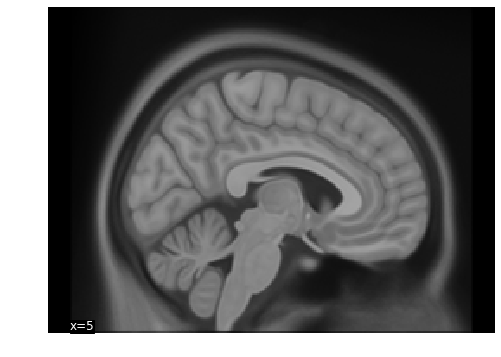

In [22]:
t1_file = r'./sgen_notebook_data/MNIBrain152/mni_icbm152_nlin_sym_09a_nifti/mni_icbm152_nlin_sym_09a/mni_icbm152_t1_tal_nlin_sym_09a.nii'
fig, ax = plt.subplots(figsize=(8, 6))
plot_anat(t1_file, display_mode='x', cut_coords=[5], draw_cross=False, axes=ax)

As the Margulies et al. 2009 method was only concerned with the anterior cingulate cortex, they only modeled the anterior part of the corpus callosum, using a single quadratic function. Using that function and the rules listed above, these are the seeds that they generated:

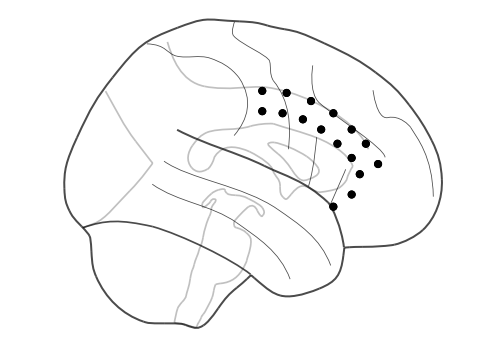

In [66]:
full_coords = pd.read_csv(r'sgen_notebook_data/seed_coordinates.csv', index_col=0)
acc_list = [i for i in full_coords.index if "ACC" in i]
acc_coords = full_coords.filter(acc_list, axis='index').values

fig, ax = plt.subplots(figsize=(8, 6))
n = len(acc_coords)
plot_connectome(np.zeros(shape=[n, n]), acc_coords, ['k']*n, display_mode='x', axes=ax)

As you can see from the anatomical image, the shape of the posterior corpus callosum is not amenable to being modeled as one curve. Therefore, we modeled it using an intersection of two second-order polynomials.

In [68]:
#Prep work
def fgen(x, a, b, c):
    #Solve second order polynomials
    form = lambda x: a*x**2 + b*x + c
    return form(x)

file = r"./sgen_notebook_data/callosal_curve_coordinates_excel.xlsx"
sheets = ["UpperCurveCoords", "LowerCurveCoords"]
cc_coords = pd.read_excel(file, sheet_name=sheets, header=None)

poly1_cc_2d = cc_coords['UpperCurveCoords'].values[:, 1:]
poly2_cc_2d = cc_coords['LowerCurveCoords'].values[:, 1:]

x = np.arange(0, 60, .5)

The curves were calculated by recording the boundary coordinates of the corpus callousm. Then those coordinates were split into two sets of coordinates on which a second-order polynomial solution could be fitted onto. 

Note: because we are restricted to 1mm voxel space, the shape of the corpus callosum can only be described using whole numbers (see anatomical image for reference). 

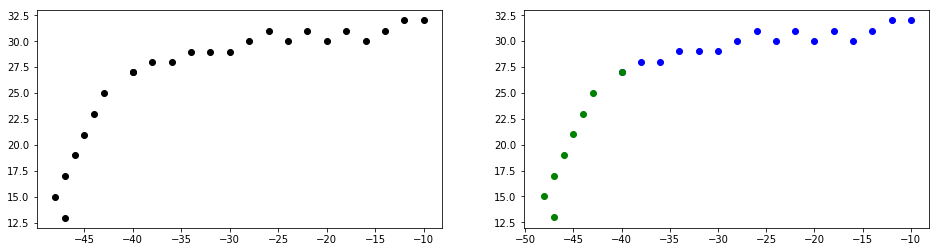

In [80]:
full_coords = np.vstack((poly1_cc_2d, poly2_cc_2d))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.scatter(x=full_coords[:, 0], y=full_coords[:, 1], c='k')

ax2.scatter(x=poly1_cc_2d[:, 0], y=poly1_cc_2d[:, 1], c='b')
ax2.scatter(x=poly2_cc_2d[:, 0], y=poly2_cc_2d[:, 1], c='g')

Using the two sets of coordinates, we'll solve some second-order polynomials.

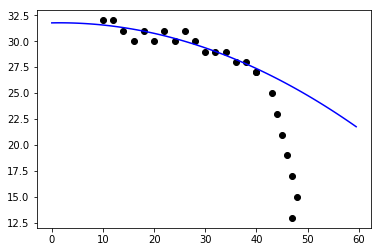

In [85]:
full_coords[:, 0] = full_coords[:, 0] * -1
poly1_x = poly1_cc_2d[:, 0] * -1 
poly1_y = poly1_cc_2d[:, 1]

poly2_x = poly2_cc_2d[:, 0]
poly2_y = poly2_cc_2d[:, 1]

params = np.polyfit(poly1_x, poly1_y, 2)
poly1_func = fgen(x, params[0], params[1], params[2])

params = np.polyfit(poly2_x, poly2_y, 2)
poly2_func = fgen(x, params[0], params[1], params[2])

fig, ax = plt.subplots()
ax.scatter(x=full_coords[:, 0], y=full_coords[:, 1], c='k')
ax.plot(x, poly1_func, 'b-')